In [3]:
import torch
import torch.nn as nn
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import chess
from nnue import HIDDEN_SIZE, INPUT_SIZE, EVAL_SCALE, fen_to_onehot, NNUE
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
df = pd.read_csv("./chessData/BigOne.csv")

In [5]:
df['score'] = df['Evaluation'].map(lambda x : 0.5 + min(1000, max(-1000, int(x.replace('#', '')))) / 2000)

In [6]:
df.head(10)

,FEN,Evaluation,score
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10,0.4950
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56,0.5280
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9,0.4955
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52,0.5260
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26,0.4870
5,rnbqkb1r/ppp2ppp/4pn2/3p4/3PP3/8/PPPN1PPP/R1BQ...,+50,0.5250
6,rnbqkb1r/ppp2ppp/4pn2/3pP3/3P4/8/PPPN1PPP/R1BQ...,+10,0.5050
7,rnbqkb1r/pppn1ppp/4p3/3pP3/3P4/8/PPPN1PPP/R1BQ...,+75,0.5375
8,rnbqkb1r/pppn1ppp/4p3/3pP3/3P1P2/8/PPPN2PP/R1B...,+52,0.5260
9,rnbqkb1r/pp1n1ppp/4p3/2ppP3/3P1P2/8/PPPN2PP/R1...,+52,0.5260


In [7]:
BATCH_SIZE = 512
testing_df = df.sample(frac=0.01)
training_df = df.drop(testing_df.index)
train_dataset = np.array_split(training_df[['FEN', 'score']], int(len(training_df) / BATCH_SIZE))
test_dataset = np.array_split(testing_df[['FEN', 'score']], int(len(testing_df) / BATCH_SIZE))

c:\Users\monte\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\monte\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [8]:
class TrainingNNUE(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.l1 = nn.Linear(INPUT_SIZE, HIDDEN_SIZE, bias = True)
        self.l2 = nn.Linear(2 * HIDDEN_SIZE, 1, bias = True)

    def forward(self, x):
        x = self.l1(x)      # (B, H)
        x = torch.concat((x, -x), dim=-1)   # (B, 2*H)
        x = torch.square(torch.clip(x, 0, 1))
        x = self.l2(x)
        return torch.sigmoid(x)


In [11]:
model = TrainingNNUE()
#model.load_state_dict(torch.load("./models/nnue1.ckpt", weights_only=True))
model.cuda()
total_losses = []
total_test_losses = []


In [12]:
loss_func = nn.SmoothL1Loss()
optimizer = torch.optim.AdamW(model.parameters())

n_epochs = 1
for epoch in range(n_epochs):
    losses = []
    test_losses = []

    # Training epoch
    model.train()
    for batch in tqdm(train_dataset):
        batch_targets = torch.FloatTensor(batch['score'].values).cuda()
        batch_inputs = torch.FloatTensor(np.array([fen_to_onehot(f) for f in batch['FEN'].values])).cuda()

        outputs = model(batch_inputs)
        loss = loss_func(torch.flatten(outputs), batch_targets)

        loss_val = loss.cpu().detach().numpy()
        losses.append(loss_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Testing epoch
    model.eval()
    with torch.inference_mode():
        for batch in tqdm(test_dataset):
            batch_targets = torch.FloatTensor(batch['score'].values).cuda()
            batch_inputs = torch.FloatTensor(np.array([fen_to_onehot(f) for f in batch['FEN'].values])).cuda()

            outputs = model(batch_inputs)
            loss = loss_func(torch.flatten(outputs), batch_targets)

            loss_val = loss.cpu().detach().numpy()
            test_losses.append(loss_val)

    total_losses.append(np.mean(losses))
    total_test_losses.append(np.mean(test_losses))
    print('Epoch', epoch, '- train loss', np.mean(losses), '- test loss', np.mean(test_losses))

torch.save(model.state_dict(), "./models/nnue2.ckpt")

100%|██████████| 253/253 [00:27<00:00,  9.10it/s]

Epoch 0 - train loss 0.0094093615 - test loss 0.008576087


In [19]:
torch.onnx.export(model, (torch.FloatTensor(fen_to_onehot(chess.Board.starting_fen)),) ,f="C:/Users/monte/Informatique/Chess/rust/cheese-engine/pyNNUE/models/nnue2.onnx")

[torch.onnx] Obtain model graph for `TrainingNNUE([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `TrainingNNUE([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 1 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 20},
            producer_name='pytorch',
            producer_version='2.9.0+cu126',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"x"<FLOAT,[789]>
            ),
            outputs=(
                %"sigmoid"<FLOAT,[1]>
            ),
            initializers=(
                %"l1.bias"<FLOAT,[256]>{TorchTensor(...)},
                %"l2.bias"<FLOAT,[1]>{TorchTensor<FLOAT,[1]>(Parameter containing: tensor([0.0225], requires_grad=True), name='l2.bias')},
                %"val_0"<FLOAT,[789,256]>{Tensor(...)},
                %"val_6"<FLOAT,[512,1]>{Tensor(...)},
                %"concat_min"<FLOAT,[]>{Tensor<FLOAT,[]>(array(0., dtype=float32), name='concat_min')},
                %"concat_max"<FLOAT,[]>{Tensor<FLOAT,[]>(array(1., dtype=float32), name='concat_max')},
                %"val_5

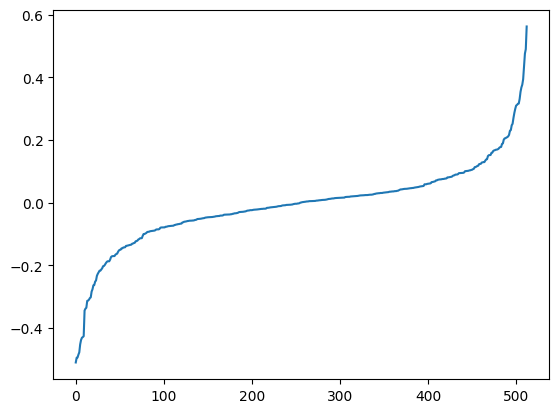

In [14]:
with torch.inference_mode():
    batch = test_dataset[1]
    batch_targets = torch.FloatTensor(batch['score'].values).cuda()
    batch_inputs = torch.FloatTensor(np.array([fen_to_onehot(f) for f in batch['FEN'].values])).cuda()

    outputs = model(batch_inputs)
    l = list((torch.flatten(outputs) - batch_targets).cpu())
    l.sort()
    plt.plot(l)


In [16]:
model.eval()
model.cpu()
with torch.inference_mode():
    print(model(torch.FloatTensor(fen_to_onehot(chess.Board.starting_fen))))

tensor([0.5425])
